# Week 4 - Statistical testing, correlations and predictions
This week we will continue using the [NeurOlympics](http://neurolympics.nl/) dataset on football players to demonstrate more interesting statistical tools. In this tutorial we will show how to do:

- Permutation tests
- ANOVA
- Correlations
- Regressions

We have already used some of the important libraries but you have yet to work with [SciKit Learn](http://scikit-learn.org/stable/). SciKit Learn (or sklearn as you'll be importing it as) is an impressive library for machine learning built on NumPy, SciPy, and matplotlib. This library has functions for almost everything you'll ever need for data mining and analysis.

But lets start with importing our libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # This is a well-known package for plotting
import seaborn as sns
import warnings # just to remove annoying warnings that can pop up
warnings.filterwarnings("ignore")
# This is called a magic function and is specific for notebooks.
# This helps us plot inside our notebook (not actually necessary, but its nicer)
%matplotlib inline

In [2]:
# lets load our data
df = pd.read_csv('FootballData_anonymous.csv')
# Many columns have very long names, but one is unnecessarily long. Lets change that.
df = df.rename(index=str,
                 columns={'decision (1 = not good enough, 2 = no decision yet, 3 = prof contract)': 'Contract'})

### Non-parametric testing
Lets steal some text from [wikipedia](https://en.wikipedia.org/wiki/Nonparametric_statistics): *Unlike parametric statistics, nonparametric statistics make no assumptions about the probability distributions of the variables being assessed. The difference between parametric models and non-parametric models is that the former has a fixed number of parameters, while the latter grows the number of parameters with the amount of training data. Note that the non-parametric model does, counterintuitively, contain parameters: the distinction is that parameters are determined by the training data in the case of non-parametric statistics, not the model.* 

One very useful nonparametric test is the permutation test. Here we estimate a null distribution by randomly shuffle our observed values, create two new groups based on the shuffled data and save the differences between these groups. If our observed differences is better than 95% of our null distribution, we say that we have a significant difference. It is very easy to implement your own permutation test, see below for an example:

In [ ]:
# we can set a default value for our parameters when defining our functions
# Now this function will run fine without the user having to specify how many
# iterations (because the default is nrand = 1000), or which tail 
# (since tail=0)
def permutation_test(x, y, nrand=1000, tail=0):
    """
    Daniel Lindh 2017
    Computes a distribution, which the observed mean difference is tested against
    This test is for non-paired observations
    Args:
        x (array/list): The first variable.
        y (array/list): The second variable.
        nrand (integer): Number of iterations
        Tail (integer):
            -1: one-tailed x > y
             0: two-tailed x != y
             1: one-tailed x < y
    Returns:
        p (float): p-value 
        
    """
    # Lets make sure we are working with numpy arrays
    x, y = np.array(x), np.array(y)
    
    # This is our observed mean difference
    xydiff = x.mean()-y.mean()
    
    # Lets permute the values, divide into two variables
    # save the mean difference into a list
    # First put x and y in one large array
    xy = np.hstack((x, y))
    sizeX = len(x)
    sizeY = len(y)
    
    # we want to save our randomized mean differences in a list
    estimates = []
    for i in range(nrand):
        # we shuffle the values and create two 
        # groups the same size as x and y
        np.random.shuffle(xy)
        tempX = xy[:sizeX]
        tempY = xy[-sizeY:]
        # Append the mean difference to our list
        estimates.append(tempX.mean()-tempY.mean())
    
    # Two tailed x != y
    if tail == 0:
        diffCount = sum(np.abs(estimates) <= np.abs(xydiff))
        p = (1 - (diffCount/nrand))*2
        
    # One-tailed x > y
    elif tail == -1:
        diffCount = sum(estimates <= xydiff)
        p = diffCount/nrand
        
    # One-tailed x < y
    elif tail == 1:
        diffCount = sum(estimates <= xydiff)
        p = 1 - (diffCount/nrand)
    else:
        raise ValueError('Not a valid tail. Please choose -1, 0, or 1.')

    return p

In [ ]:
from scipy.stats import ttest_ind # lets import the independent t-test function for comparison

# lets define some arbitrary values
x = [14, 15, 16, 55, 5, 77, 88, 89]
# And another one with obviously lower values
y = [3, 4, 66, 7, 7, 3, 1, 4, 1, 1]

# lets call our permutation function and compare it to the t test
p1 = permutation_test(y, x, 10000)
t, p = ttest_ind(x, y)
print('Independent t-test p = ', p, '\nPermutation test p = ', p1)

<div class='alert alert-warning'>
**ToDo**:
Change the permutation test function so it returns the null distribution as well. Then execute the code below to print this distribution and our observed difference. Stuck? Click [here](http://lmgtfy.com/?q=python+function+return+multiple+values) ;)
</div>


In [ ]:
x = np.array([14, 15, 16, 55, 5, 77, 88, 89])
y = np.array([3, 4, 66, 7, 7, 3, 1, 4, 1, 1])

# We call our permutation test function, expecting two objects returned
# the first object should be the p-value and the second is the null distribution
p, null = permutation_test(y,x, 10000, -1)

# lets plot the null distribution
sns.distplot(null)

# lets plot a red circle on the x-axis indicating our observed value
plt.plot(x.mean()-y.mean(), 0, 'ro', markersize=10)

# Lets add some text. xy-parameter decides where the arrow should point, xytext-parameter decides
# the origin of the text
plt.annotate('Our observed mean difference', xy=(x.mean()-y.mean(), 0), xytext=(x.mean()-y.mean()+10, 0.015),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=15)

plt.title('Permutation test: Null distribution and observed difference\np = {}'.format(p))
plt.show()

### ANOVA
Analysis of Variance, or **ANOVA**, is a useful statistical tool to measure differences in variance within (Sum of squares within) and between groups (sum of squares between). ANOVA is a powerful parametric test where you can test whether or not there is a difference in means between several groups (as in contrast to only two groups). In python there are several ways of doing a one-way ANOVA. Lets have a look at two of them to find out if there is a difference in ATTENTION_RT_mean over 3 different age groups:
- 12 => x years old
- 12 < x > 18 years old
- 18 < x years old

In [ ]:
# The first one is using SciPy
import scipy.stats as stats

# lets make our groups and extract data
below_12 = df[df['age'] < 13].ATTENTION_RT_mean.values
between_13_18 = df[(df['age'] > 12) & (df['age'] < 19)].ATTENTION_RT_mean.values
above_18 = df[df['age'] > 18].ATTENTION_RT_mean.values

# We can send in each group as a different argument into the f_oneway-function

print(stats.f_oneway(below_12 ,between_13_18, above_18))

### Two-way ANOVA (optional)

Making a one-way ANOVA in python is simple. However, doing a two-way anova can be a bit more trickier. For those of you who are interested, [Erik Marsja](https://www.marsja.se/three-ways-to-carry-out-2-way-anova-with-python/) explains three ways of doing it in Python. Lets see how one of these solutions would work with our data. Lets say we want to know how age group and contract affects the data in column ATTENTION_RT_mean.

In [ ]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# lets create a new column called age group
df['age_group'] = np.zeros([len(df),1])

# lets loop over each player, and add values 1, 2, 3 to the age_group column
# dependent on if they over younger than 13, between 13-18, or older ethan 18
for i in range(len(df)):
    if df['age'][i] < 13:
        df['age_group'][i] = 1
    elif df['age'][i] > 18:
        df['age_group'][i] = 3
    else:
        df['age_group'][i] = 2

In [ ]:
# These power calculations are taken from Marsjas website

def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov
 
def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov
 

In [ ]:
"""
This string below is a patsy formula for a regression fit (more about this in the end of this tutorial).
We want to fit age group and Contract to ATTENTION_RT_mean
We first name our dependent variable, and then after the tilde we name the predictors
and lastly the interactions we are interested in (age_group:C(Contract) in this case)
Describing Contract with C() lets patsy know it is a categorical variable
"""
formula = 'ATTENTION_RT_mean ~ age_group + C(Contract) + age_group:C(Contract)'

# lets fit our model with the formula and data
model = ols(formula, df).fit()
# send it to the anova for linear models
aov_table = anova_lm(model, typ=2)

# lets call the functions we defined above to add the power measurements
eta_squared(aov_table)
omega_squared(aov_table)

# And print the results
print(aov_table)

There is significant main effects of Contract and age group, however no significant interaction between the two. We can also see that age group explains around 18% of the variance.

### Correlations
As you know, certain cognitive traits develop later in life. Lets find out if there is any statistical relationship between **ANTICIPATION_pointspersecond** and **age**. To test this we can try and use Pearsons correlation. The pearson correlation is a measurement of how strong the relationship is between two variables. The coeffiecent ranges between -1 to 1, where -1 is perfectly anticorrelated and 1 is a perfect correlation. This is the formula: <br/>
<img src='pearsons.gif' style="float:left;width:200px;height:120px;"><br/><br/><br/><br/><br/><br/>

**Here is a simple implementation:**

In [ ]:
# This is how we define functions
# You should definitely know this by now :)
def my_pearsonr(x, y):
    """
    Daniel Lindh 2017
    Returns the correlation coeffecient between x and y
    Args:
        x (array)/list: The first variable.
        y (array/list): The second variable.
    Returns:
        r (float): The pearson correlation coeffecient r
    """
    # Lets make sure we are dealing with numpy arrays
    x, y = np.array(x), np.array(y)
    
    # lets make sure x and y are the same length
    assert len(x) == len(y), 'x and y need to be the same length!'
    
    n = len(x)
    # lets take the dot product of x and y 
    # this corresponds to Exy
    # we could also have used sum(x*y)
    sum_xy = np.dot(x, y) 
    
    # lets set up the nominator and the denominator
    r = (n*sum_xy-sum(x)*sum(y)) / (np.sqrt((n*sum(x**2)-sum(x)**2) * (n*sum(y**2)-sum(y)**2)))
    return r   

<div class='alert alert-info'>
**ToThink**: Make sure you understand the correspondance between the formula and the code
</div>

However, we don't really have to define our own functions for statistical testing. In python we have several really handy statistical packages, such as SciPy. Scipy comes with a lot of useful statistical tests. Lets import a pearsons r:

In [ ]:
from scipy.stats import pearsonr

Now we can test our data for linear relationships:

In [ ]:
age = df['age']
ANT_pps = df['ANTICIPATION_pointspersecond']

# pearsonsr returns 2 values. We can unpack them directly like this
r, p = pearsonr(age, ANT_pps)

#lets evaluate our own pearson implementation as well:

r2 = my_pearsonr(age, ANT_pps)

print('SciPy pearson r: ', r, '\nOur DIY r: ', r2)
print('p-value: ', p)

**Good news**! Our implementation returns the exact same results. *Even better news*, the p-value is through the roof. As we can see it is 46 zeros, followed by 9, way below a typical alpha value of 0.05.

<div class='alert alert-warning'>
**ToDo**:
Copy paste the code above, make a new variable that only contains data from people who we know did or didn't get a contract (i.e. everyone either coded 1 or 3 in the "Contract" column). Test the relationship again.
</div>

In [ ]:
# copy paste above code here

## Regression models and predictions
This section will be the most advance, most useful thing you will get to this course. Machine learning has become one of the most popular terms in recent years. It refers to a collection of methods for predicting data based on one or several attributes. One of the most basic and important machine learning concepts is regression models. In supervised machine learning we call the outcome we want to predict the target variable (usually denoted with lower case y), and the attributes, or features, used to predict are called predictive variables. The predictive variables are usually labeled lower case x, when its a single variable, or upper case X if it is multivariate.

In the X-variable, observations are stored in rows and features are stored in the columns. Lets say we have measured the temperature over the course of 10 days, which we want to use to predict ice cream sales. Our X-variable would look something like this:

|Temperature|
|-|
|20.4|
|12.1|
|13.4|
|23.0|
|29.7|
|28.4|
|19.0|
|13.4|
|14.1|
|13.4|


While our y-variable might look like this:

|Ice Cream Sales|
|-|
|22|
|13|
|13|
|33|
|34|
|38|
|16|
|11|
|12|
|14|


Now, we can try and see how we can fit the temperature and rain information to ice cream sales.

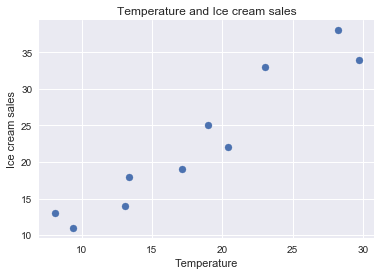

In [3]:
# Define our predictor array
x = np.array([20.4,
            8.1,
            13.4,
            23,
            29.7,
            28.2,
            19,
            9.4,
            17.1,
            13.1])

# Define our target array
y = np.array([22, 13, 18, 33, 34, 38, 25, 11, 19, 14])

# Lets plot the temperature on x and ice cream sales on y
plt.scatter(x, y)
plt.title('Temperature and Ice cream sales')
plt.ylabel('Ice cream sales')
plt.xlabel('Temperature')

plt.show()

### Dimensions
**Important**! Regression models expect our x/X-data to be in two dimensions.
This is important. If we only have one variable in our predictor array
we need to make sure it is still 2-dimensional

In [4]:
# Now we print and see its only 1 dimension
print('Temperature has only one dimesion:', x.shape)
print(x)
# Lets use reshape, to add a dimension
x = x.reshape([len(x), 1])
print('Now temperature has two dimesions:', x.shape)
print(x)

Temperature has only one dimesion: (10,)
[ 20.4   8.1  13.4  23.   29.7  28.2  19.    9.4  17.1  13.1]
Now temperature has two dimesions: (10, 1)
[[ 20.4]
 [  8.1]
 [ 13.4]
 [ 23. ]
 [ 29.7]
 [ 28.2]
 [ 19. ]
 [  9.4]
 [ 17.1]
 [ 13.1]]


*Its important to realize that we haven't added any values here. Just made sure its in a column*

### Fitting the data
The typical formula for ordinary least square where we have only one predictor is: $y = \beta_1 x + \beta_0$

Here, our goal is to estimate the $\beta s$, where $\beta_1$ is the slope and $\beta_0$ is the intercept. This can be done analytically or through iterative processes (for example gradient descent). However, there are several ways of doing this automatically in python, and you don't have to worry too much of what is happening under the hood. Lets import a linear model from SciKit learn, and fit temperature to ice cream sales:

In [5]:
# lets import a linear regression model
from sklearn.linear_model import LinearRegression

# Make an instance of our LinearRegression-class
lr = LinearRegression()
# Now we fit our data
lr.fit(x, y)

# Now we can have look at the Beta (coefficient, aka the slope) and our intercept/B0
# (where our line crosses y at x = 0)
print('slope = {}, intercept = {}'.format(lr.coef_[0], lr.intercept_))

slope = 1.2328012984153134, intercept = 0.33698444674621797


**Lets plot our data again, and add a regression line using the beta and the intercept from our fit**

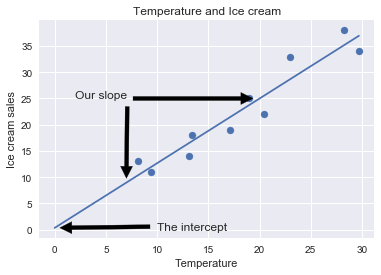

In [6]:
# Plot temperature and sales
plt.scatter(x, y) 

# we want a point at x = zero, and at x = max value for temperature
x_l = [0, max(x)]
# Lets use our beta and intercept to figure out where on the y-axis they correspond
# by using y = b*X+b0
y_l = [lr.coef_ * x_l[0] + lr.intercept_, lr.coef_ * x_l[1] + lr.intercept_]

plt.plot(x_l, y_l)

# Now lets annotate with arrows our found values

plt.annotate('The intercept', xy=(0, lr.intercept_), xytext=(10, 0),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12)

plt.annotate('Our slope', xy=(7, 9), xytext=(2, 25),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12)
plt.annotate('', xy=(20, 25), xytext=(7, 25),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12)

plt.title('Temperature and Ice cream')
plt.ylabel('Ice cream sales')
plt.xlabel('Temperature')
plt.show()

### Predictions

Now we can predict ice cream sales with new, unobserved temperatures:

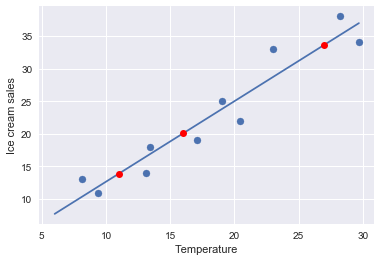

We predict that 11 degrees will result in 14 ice creams being sold
We predict that 16 degrees will result in 20 ice creams being sold
We predict that 27 degrees will result in 34 ice creams being sold


In [7]:
# Lets predict ice cream sales for these temperatures
new_x = [[11], [16], [27]] # list within list, this gives 2 dimensions
pred = lr.predict(new_x)

"""
What is important to understand that all of our predictions now will end up on the regression line
we just drew above. Lets plot and see what it looks like!
"""

# this is basically the same thing we plotted above
plt.scatter(x, y) 
x_l = [6, max(x)]
y_l = [lr.coef_ * x_l[0] + lr.intercept_, lr.coef_ * x_l[1] + lr.intercept_]
plt.plot(x_l, y_l)
plt.xlabel('Temperature')
plt.ylabel('Ice cream sales')

# Now lets add our predicted values to the plot (red circles)
plt.plot(new_x, pred, 'ro')
plt.show()

# Now lets iterate over the new temperatures and the predicted ice cream sales
for i in range(len(pred)):
    print('We predict that {0} degrees will result in {1:.0f} ice creams being sold'.format(new_x[i][0], pred[i]))

<div class='alert alert-info'>
**ToThink**: 
In the above code we do this operation to calculate the point on the y-axis:<br/>
</div>

```python
lr.coef_ * x_l[0] + lr.intercept_
```

<div class='alert alert-info'>
Make sure you understand how this relates to:
</div>
$y = \beta_1 x + \beta_0$

<div class='alert alert-info'>
And that this is crucial for how we make predictions
</div>

As you can see that since our predictions always will fall on the line, we will have some type of error in our predictions (its quite unlikely that an observed value would land exactly on the line). More on this later.

<div class='alert alert-warning'>
**ToDo**:
Finish the code below! Make a function called <b>fit_predict_print</b> that takes the arguments:<br />
X - a two dimensional array with features on the columns and observations by rows<br />
y - an array with target values<br />
lr - an instance of a linear model<br />
The function fits the data and for each observation prints out:<br />
"Actual: [insert y-data] - Predicted: [insert prediction]"<br />
We should call the function with:
</div>
```python
lr = LinearRegression()
fit_predict_print(X, y, lr)
```


In [ ]:
lr.fit(x, y)
# If we now send in X to predictions we can see how far away the solution we were
prediction = lr.predict(x)

# lets print out the predicted and actual (y) ice cream sales
print(prediction)
print(y)

In [ ]:
# And this code should be used to test your function
lr = LinearRegression()
fit_predict_print(x, y, lr)

### The intercept
When using LineraRegression (or any other model) in scikit learn, the intercept is automatically fitted. However, if you want to do this yourself, you need to add a column of ones in your array. Lets turn off intercept and see what happens:

In [ ]:
# Not fitting the intercept
lr = LinearRegression(fit_intercept=False)
# we can fit and directly predict by doing this:
no_intercept_pred = lr.fit(x, y).predict(x)
print('With no intercept:', no_intercept_pred)

# Fitting the intercept by adding a column of ones ourselves
lr = LinearRegression(fit_intercept=False)
# hstack and vstack are two ways of concatenating arrays, either horizontally or vertically 
x_intercept = np.hstack((x, np.ones((len(y),1))))
my_intercept_pred = lr.fit(x_intercept, y).predict(x_intercept)
print('\nWith my intercept:', my_intercept_pred)

# And what it looks like when we let the class instance do it by itself
# we don't need to say fit_intercept=True, this is the default
lr = LinearRegression()
no_intercept_pred = lr.fit(x, y).predict(x)
print('\nWith default intercept:', no_intercept_pred)

As you can see, the two last options ends up being the same. The difference from the first option, where we don't fit the intercept, is small. However, this could end up being detrimental for your results if you don't know what is happening, especially if you want to solve this yourself. **In fact**, you can easily solve $\beta $ with one line of code using matrix algebra (**YAY**): 
$\beta =(X′X)^{−1} X′y$

Since we all love doing these type of things, lets try it out quickly:

In [ ]:
# We are adding the column of ones as earlier.
# In order to do matrix algebra, we also need to turn our arrays into matrices
x_mat= np.mat(np.hstack((x, np.ones((len(y),1)))))
y_mat = np.mat(y).T

# lets start by fitting it using sklearn
lr = LinearRegression(fit_intercept=False)
lr.fit(x_mat, y)
betas = lr.coef_
print('Betas:', betas)

# Now the same thing by ourselves using the matrix formula above
# T = transpose of matrix 
# I = inverse of matrix
my_betas = (x_mat.T * x_mat).I * x_mat.T * y_mat
print('My betas:', my_betas.ravel())

Here, since we added the column of ones as the second column, the second beta we get out is the **intercept / $\beta 0$**. You can easily make sure this is the case by comparing it with values from when we first printed out the slope and the intercept above. Knowing this: $y = \beta_1 x + \beta_0$ you can easily calculate the predicted ice cream sale yourself based on any temperature.

### Accuracy and Coefficient of determination
One way to evaluate the efficacy of a model is to calculate the mean squared error (MSE), where **lower** values means better fit. However, a standardized measure of this is the $R^2$, or the coefficient of determination. There are two simople ways to calculate this. 

1. First by calculating the MSE for our prediction and then normalize it by the MSE of the mean. The rationale is that if our variables are informative, we should predict the outcome with less error than the mean.
2. The second way is to square the pearson correlation between target and prediction

In [ ]:
# This is the first way. Lets start by fitting our data and then
# calculating the MSE for our prediction
lr.fit(x, y)
pred = lr.predict(x)
MSE = np.mean((pred-y)**2)

# And now the mse for the mean
mean_MSE = np.mean((np.mean(y)-y)**2)

R2_1 = (mean_MSE - MSE) / mean_MSE
R2_2 = pearsonr(y, pred)[0]**2
# print results
print('R2 from sum of squared errors:', R2_1)
print('R2 from squared pearsons r:', R2_2)


The $R^2$ tells you how much of the variance is explained by the predicting variables, more of which you can read [here](https://en.wikipedia.org/wiki/Coefficient_of_determination)!

## Multivariate and Generalizability!
Alright, cool. So we can find the intercept and the slope between two variables. However, this method easily extends to multivariate problems, where we can get better predictions if we use information from several variables to predict our target. Lets try it out on our football dataset.

Additionally, above we are evaluating our models on the same X that we used to train it on. This is incredibly dangerous for interpretation, because we are very likely to overfit our data, believing it to be much better than it acutally is. One way to solve this is to divide your data into a training and test set. This is called **cross-validation**, and is a cornerstone in all types of data science. Lets do this on our **football** dataset, and where try to predict age based on a few WM scores! 

We could randomly pick out half of the people from our data set and use these at training data, or we can just use a convenient function from scikit learn called **train_test_split**:


In [ ]:
from sklearn.model_selection import train_test_split

# lets pick out WM1, WM2, WM3 (you can use shape to check that this yields an (1086, 3) array)
X = df[['WM1', 'WM2', 'WM3']]
# and our target
y = df['age']

# lets split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# lets print the size of X_train and X_test. Since we set test_size to 0.5, they should be equally large
print(X_train.shape, X_test.shape)

In [ ]:
# Excellent! Now lets train our regressor model and see how well we do!

lr = LinearRegression()
# fit train data
lr.fit(X_train, y_train)
# predict test data
X_pred = lr.predict(X_test)

# lets make a scatterplot with our prediction on the y-axis, and our target value on the x axis

plt.scatter(y_test, X_pred)
plt.xlabel('Actual age')
plt.ylabel('Predicted age')

# Lets put the pearson r and MSE in the title
r, p = pearsonr(y_test, X_pred)
MSE = np.mean((y_test-X_pred)**2)

plt.title('Predicted and actual age\npearson r = {0:.3f} - MSE = {1:.3f}'.format(r, MSE))
plt.show()

## Wow! 
It looks like we very simply can train a regression model to predict age accurately for independent data based on a few working memory scores. 

<div class='alert alert-info'>
**ToThink**: 
What would a negative pearson correlation mean for our fit?
</div>

<div class='alert alert-warning'>
**ToDo**:
Now try to predict age using 5 columns of your choice, calculate the coefficient of determination and see if its better
</div>

In [ ]:
# Put your solution here

### What? You want more machine learning? Fine.
What you have seen here is just the tip of the iceburg! For a selection of available supervised learning models, click [here](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning)! If you want to try it out, you can easily change from a normal linear regression (like above) to a more advanced support vector regression:

```python
from sklearn.svm import SVR
lr = SVR()

lr.fit(X_train, y_train)
# predict test data
X_pred = lr.predict(X_test)

etc.
```

However, its not guaranteed this will yield better results.